# **<font color='gren'>Exercício Bônus**

**Aluno: Vitor Alexandre Garcia Vaz**

**Número USP: 14611432**

## **Imports**

In [195]:
import numpy as np
import matplotlib.pyplot as plt 
import time 
import scipy
from scipy import sparse

## **Definição da rede**


### Função de definição da rede

In [196]:
def GeraRede(nx,ny,CH,CV):
    nv = nx*ny
    nc = (nx-1)*ny + (ny-1)*nx
    
    conec = np.zeros(shape=(nc,2),dtype=np.int64)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(ny):
        for i in range(nx-1):
          k = j*(nx-1) + i
          conec[k,0] = j*nx + i
          conec[k,1] = j*nx + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(nx):
      for j in range(ny-1):
          k = (nx-1)*ny + j*nx + i
          conec[k,0] = i + j*nx
          conec[k,1] = i + (j+1)*nx
          C[k] = CV

    return nv, nc, conec, C

## **Funções Necessárias**

### 1- Monta matriz conduc e matriz A

In [197]:
def retorna_conduc(C):
    tam=len(C)
    conduc=np.zeros(shape=(tam,tam),dtype=np.float64)
    for i in range(tam):
        conduc[i][i]=C[i]
    return conduc


def retorna_matriz_A(conec,nc,nv,conduc):
    #Inicia a matriz A que será retornada
    A=np.zeros(shape=(nv,nv),dtype=np.float64)
    
    n1,n2=0,0

    for i in range(nc): # percorre as linhas da matriz de conecções
        
        #recebimento dos nós da linha i da matriz de conecções
        n1,n2=conec[i][0],conec[i][1]

        # adição de elementos conforme a matriz ClocK
        A[n1][n1]=A[n1][n1]+conduc[i][i]    
        A[n1][n2]=A[n1][n2]-conduc[i][i]
        A[n2][n1]=A[n2][n1]-conduc[i][i]
        A[n2][n2]=A[n2][n2]+conduc[i][i]
                        
    
    return A

### 2-Função de formação da matriz Ã e matriz direita

In [198]:

def retorna_matriz_Ã(A,natm):
    rng=len(A[0])
    Ã=A
    for i in range(0,rng):
        if(i==natm):
            Ã[natm][i]=1
        else:
            Ã[natm][i]=0
    return Ã

def retorna_matriz_direita(nv,nB,QB):
    d=np.zeros(nv,dtype=np.float64)
    for i in range(0,nv):
        if(i==nB): d[i]=QB
        else: d[i]=0
    return d



### 3-Função de resolução do sistema e de vazões nodais

In [199]:
def retorna_pressoes(Ã,d):
    #Obtém a matriz exparsa da matriz Ã
    Ã_aux = scipy.sparse.csr_matrix(Ã)

    #Obtém vetor de pressões
    P = sparse.linalg.spsolve(Ã_aux, d)
    return P

def vetor_vazoes_nodos(A,P):
    Q=A@P
    return Q

### 4-Obtenção do vetor de vazões nos canos e da potência da bomba

In [200]:
def retorna_potencia(conduc,D,P):
    Qc=conduc@D@P
    W=(Qc.transpose())@(D@P)
    return W

### 5-Obtenção da matriz D(diferenças)

In [201]:
def retorna_matriz_D(nv,nc,conec):
    l=nc
    c=nv
    D=np.zeros(shape=(l,c),dtype=np.float64)
    for i in range(l):
        n1,n2=conec[i][0],conec[i][1]
        D[i][n1]=1
        D[i][n2]=-1
    return D

### 6-Resolve o sistema

In [202]:
def resolve_sistema(natm,nB,QB,nv,nc,conec,conduc):
    A=retorna_matriz_A(conec,nc,nv,conduc)
    Ã=retorna_matriz_Ã(A,natm)
    d=retorna_matriz_direita(nv,nB,QB)
    P=retorna_pressoes(Ã,d)
    return P
   

## **Retorno da potência dissipada em função dos valores variáveis de CH e CV**

In [203]:
def potencia_dissipada(nx,ny,nB,QB,natm,CH,CV):
    nv, nc, conec, C = GeraRede(nx,ny,CH,CV)
    conduc=retorna_conduc(C)
    P=resolve_sistema(natm,nB,QB,nv,nc,conec,conduc)
    D=retorna_matriz_D(nv,nc,conec)
    return retorna_potencia(conduc,D,P)  
    

## **Obtenção dos vetores de resultados**

In [204]:
#   Pré-setagem
n=8
m=9
natm=m*n - 1
nB=0
QB=3

#   Vetores de resultados
x=np.linspace(-10000,10000,1000)*0.001
potencias1=np.array([])
potencias2=np.array([])
rng=len(x)

#    Obtenção de vetor de resultados - parte 1
for i in range (rng):
    CH=2.3+0.1*((x[i]-1)**2)
    CV=1.8+0.2*((x[i]-1)**2)
    potencias1=np.append(potencias1,potencia_dissipada(n,m,nB,QB,natm,CH,CV))

#    Obtenção de vetor de resultados - parte 2
for i in range (rng):
    CH=2.3+10*np.exp(-((x[i]-5)**2))
    CV=1.8+10*np.exp(-((x[i]-5)**2))
    potencias2=np.append(potencias2,potencia_dissipada(n,m,nB,QB,natm,CH,CV))

## **Plotagem e análise de resultados**

### Primeiro plot:

**Analisando o primeiro plot, com condutâncias se comportando como funções quadráticas de x, é possível observar que o valor de potência dissipada 6 é atingido quando os valores de x aproximam-se:**

* de valoures pouco menores que 5.0
* e de valores também pouco menores que -2.5

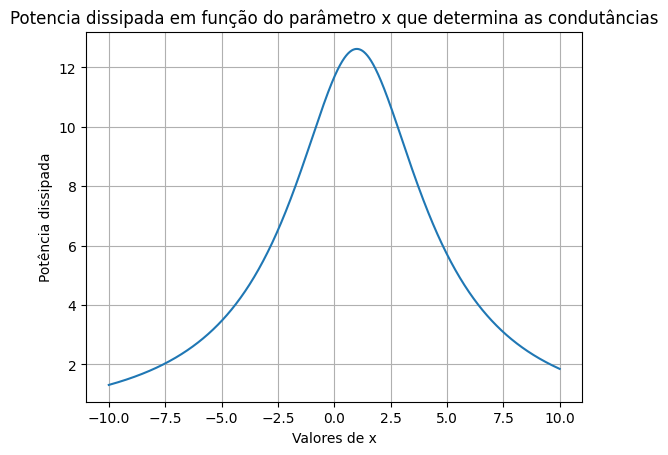

In [205]:
plt.plot(x,potencias1)
plt.grid()
plt.xlabel('Valores de x')
plt.ylabel('Potência dissipada')
plt.title('Potencia dissipada em função do parâmetro x que determina as condutâncias')
plt.show()

### Segundo plot

**Outrossim, analisando o segundo plot, com valores de condutãncias como funções exponenciais de x, é possível observar que a potência dissipada 6 é atingida quando os valores de x aproximam-se:**

* do valor 3.75

* e do valor 6.25

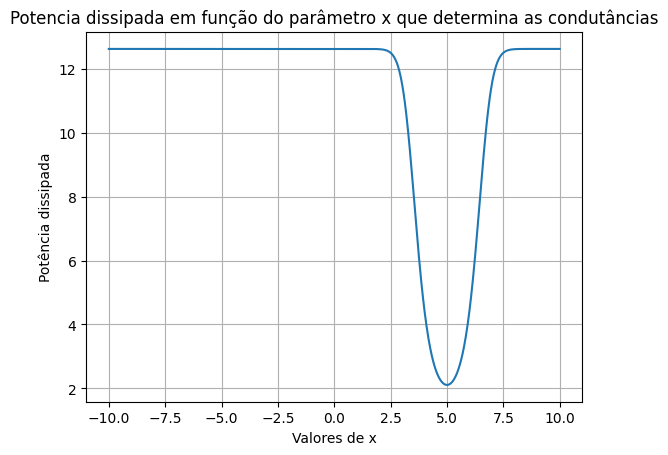

In [206]:
plt.plot(x,potencias2)
plt.grid()
plt.xlabel('Valores de x')
plt.ylabel('Potência dissipada')
plt.title('Potencia dissipada em função do parâmetro x que determina as condutâncias')
plt.show()

## 